In [1]:
import datetime
import gc
import json
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import wave
import struct

from pykalman import KalmanFilter
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, ParameterGrid

%matplotlib inline

In [37]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.rcParams['figure.figsize'] = (12, 10)

In [3]:
DATA_PATH = "C:/IHearVoicesData/"
MOTION_DIR = os.path.join(DATA_PATH, 'Motion')
AUDIO_DIR = os.path.join(DATA_PATH, 'Audio')

LAG_THRESHOLD = 3000
NUM_FFTS = 10
AUDIO_FREQ = 44000
RANDOM_STATE = 1234

In [4]:
label_df = pd.read_excel('C:/IHearVoicesData/IHearVoicesDataPrep.xlsx', header=1)
label_df = label_df.iloc[:,:8]
label_df = label_df[:29]
label_df = label_df.drop(columns=['Date', 'Date.1', 'Time', 'Time.1'])
label_df = label_df.reset_index(drop=True)
label_df.columns = ['status', 'start', 'stop', 'hours']

In [5]:
def audio_fname_to_date(fname):
    date = fname.replace('.wav', '').replace('device1_channel1_', '')
    year = int(date[:4])
    month = int(date[4:6])
    day = int(date[6:8])
    hour = int(date[8:10])
    minute = int(date[10:12])
    second = int(date[12:14])
    date = datetime.datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)
    return date


def get_files(audio_dir, min_date, max_date):
    res = []
    for fname in os.listdir(audio_dir):
        date = audio_fname_to_date(fname)
        if date > max_date:
            continue
        if date < min_date and (min_date - date).seconds / 3600 > 0.33:
            continue
        res.append(fname)
    return res


def load_audio_data(path):
    f = wave.open(path)
    dur = f.getnframes()
    sampwidth = f.getsampwidth()
    fmt = '=' + 'h' * (dur)
    data = f.readframes(dur)
    data = np.array(struct.unpack(fmt, data))
    return data


def process_audio_data(fname):
    audio_data = load_audio_data(os.path.join(AUDIO_DIR, fname))
    cur_date = audio_fname_to_date(fname)
    total_seconds = len(audio_data) // AUDIO_FREQ
    times = []
    for i in range(total_seconds + 1):
        times.extend([cur_date + datetime.timedelta(seconds=i)] * AUDIO_FREQ)
    times = times[:len(audio_data)]
    df = pd.DataFrame({'timestamp': times, 'audio': audio_data})
    df['timestamp'] = df['timestamp'].dt.floor(freq='min')
    df = df.groupby('timestamp').agg(['max', 'min', 'mean', 'median', 
                                      agg_quantile(0.25), agg_quantile(0.75), agg_power])
    df.columns = ['_'.join(col) for col in df.columns]
    return df


def get_audio_data(min_date, max_date):
    files = get_files(AUDIO_DIR, min_date, max_date)
    result_df = []
    for fname in files:
        result_df.append(process_audio_data(fname))
    pd.concat(result_df)
    return result_df


def load_motion_dataset(path):
    dataset = []
    for fname in os.listdir(path):
        df = get_motion_df(os.path.join(MOTION_DIR, fname))
        dataset.append(df)
    dataset = pd.concat(dataset)
    return dataset


def fname_to_date(fname):
    date = fname.replace('.json', '')
    year = int(date[:4])
    month = int(date[4:6])
    day = int(date[6:8])
    hour = int(date[9:11])
    date = datetime.datetime(year=year, month=month, day=day, hour=hour)
    return date


def timestamp_to_date(ts):
    return datetime.datetime.utcfromtimestamp(ts / 1000)


def agg_fft(series):
    skip_columns = ['timestamp', 'variable']
    
    result = []
    for column in series.columns:
        if column in skip_columns:
            continue

        ffts = np.abs(np.fft.fft(series[column]))[:NUM_FFTS]
        cols = ['%s_fft%d' % (column, i) for i in range(NUM_FFTS)]
        res = pd.Series(ffts, index=cols)
        result.append(res)
    result = pd.concat(result)
    return result


def agg_quantile(n):
    def quantile_(x):
        return np.quantile(x, n)
    quantile_.__name__ = 'quantile_%s' % n
    return quantile_


def agg_power(series):
    return (np.sum(series**2) / len(series))**0.5
agg_power.__name__ = 'power'



def get_motion_df(path):
    data = json.load(open(path, 'r'))['data']
    
    acc_df = []
    quat_df = []
    for row in data:
        d_row = {}
        event = row['event']
        content = event['content']
        variable = event['variable']

        d_row['timestamp'] = timestamp_to_date(row['timestamp'])
        d_row['variable'] = variable.replace('.acceleration', '') \
                                    .replace('.quaternion', '') \
                                    .replace('.batter', '')

        if 'acceleration' in variable:
            if len(content) != 4:
                print('FUCK acceleration')     
            d_row['x'] = content[0]
            d_row['y'] = content[1]
            d_row['z'] = content[2]
            # d_row['acc_shit'] = content[3]
            acc_df.append(d_row)
        elif 'quaternion' in variable:
            if len(content) != 5:
                print('FUCK quaternion')
            d_row['q1'] = content[0]
            d_row['q2'] = content[1]
            d_row['q3'] = content[2]
            d_row['q4'] = content[3]
            # d_row['q_shit'] = content[4]
            quat_df.append(d_row)    
        elif 'battery' in variable:
            continue
        else:
            print("FUCK else")
        
    acc_df = pd.DataFrame.from_dict(acc_df)
    quat_df = pd.DataFrame.from_dict(quat_df)
    return acc_df, quat_df


def generate_features(df, freq='15S'):
    df['timestamp'] = df['timestamp'].dt.floor(freq=freq)
    fft_df = df.groupby(['variable', 'timestamp']).apply(agg_fft)
    agg_df = df.groupby(['variable', 'timestamp']).agg(['min', 'max', 'mean', 'std', 'median', agg_power,
                                                       agg_quantile(0.05),
                                                       agg_quantile(0.25),
                                                       agg_quantile(0.75),
                                                       agg_quantile(0.95),
                                                       agg_quantile(0.99)])
    agg_df = agg_df.join(fft_df)
    agg_df.columns = [column if type(column) is str else '_'.join(column) for column in agg_df.columns]
    return agg_df


def add_labels(df, label_df):
    df['status'] = 'unk'
    df = df.reset_index()
    min_t = df.timestamp.min()
    max_t = df.timestamp.max()
    for i, row in label_df.iterrows():                
        df.loc[(df['timestamp'] >= row['start']) &
               (df['timestamp'] <= row['stop']), 'status'] = row['status']
    return df


def status_to_color(status):
    if status == 'Good':
        return 'green'
    if status == 'Stopped':
        return 'yellow'
    if status == 'Failure':
        return 'red'
    raise Exception("Unknown status")
    
    
def filter_unk_status(df):
    df = df[df['status'] != 'unk']
    return df.reset_index(drop=True)


def get_dataset(data_path, label_df, start_file_date=None, end_file_date=None, extract_features=True):
    result_acc = []
    result_quat = []
    for fname in tqdm(os.listdir(data_path), total=len(os.listdir(data_path))):
        date = fname_to_date(fname)
        if start_file_date is not None and date < start_file_date:
            continue
        if end_file_date is not None and date > end_file_date:
            break
        label_ind = None
        for i, row in label_df.iterrows():
            if date >= row['start'] and date <= row['stop']:
                label_ind = i
                break
        if label_ind == None:
            continue
        acc_df, quat_df = get_motion_df(os.path.join(data_path, fname))
        if extract_features:
            acc_df = generate_features(acc_df)
            quat_df = generate_features(quat_df)
        
        acc_df = add_labels(acc_df, label_df)
        quat_df = add_labels(quat_df, label_df)
        
        acc_df = filter_unk_status(acc_df)
        quat_df = filter_unk_status(quat_df)
        
        result_acc.append(acc_df)
        result_quat.append(quat_df)
        
    result_acc = pd.concat(result_acc)
    result_quat = pd.concat(result_quat)
        
    pepa_acc_df, salt_acc_df = split_by_device(result_acc)
    pepa_quat_df, salt_quat_df = split_by_device(result_quat)
    
    pepa_acc_df = pepa_acc_df.set_index(['timestamp', 'status'])
    pepa_quat_df = pepa_quat_df.set_index(['timestamp', 'status'])
    salt_acc_df = salt_acc_df.set_index(['timestamp', 'status'])
    salt_quat_df = salt_quat_df.set_index(['timestamp', 'status'])

    pepa_acc_df = pepa_acc_df.drop(columns='variable')
    pepa_quat_df = pepa_quat_df.drop(columns='variable')
    salt_acc_df = salt_acc_df.drop(columns='variable')
    salt_quat_df = salt_quat_df.drop(columns='variable')
    
    full_df = pepa_acc_df.join(pepa_quat_df, lsuffix='_pepa_acc', rsuffix='_pepa_quat') \
                     .join(salt_acc_df, rsuffix='_salt_acc') \
                     .join(salt_quat_df, rsuffix='_salt_quat')
    full_df = full_df.reset_index()
    full_df.loc[full_df['status']=='Stopped', 'status'] = 'Good'
    
    # TODO: AUDIO       
    return full_df


def split_by_device(df):
    pepa_df = df[df['variable'] == 'NGIMU-PEPA']
    salt_df = df[df['variable'] == 'NGIMU-SALT']
    return pepa_df, salt_df

In [6]:
# start_date = datetime.datetime(year=2018, month=10, day=20, hour=23)
# end_date = datetime.datetime(year=2018, month=10, day=26, hour=10)
# full_df = get_dataset(MOTION_DIR, label_df, start_file_date=start_date, end_file_date=end_date)
# full_df.to_csv("full_df.csv", index=False)

In [7]:
full_df = pd.read_csv('full_df_15s.csv', parse_dates=[0])

In [8]:
full_df = full_df.loc[2000:]
# full_df = pd.concat([full_df[:2600], full_df[:3400]])

In [9]:
encoder = LabelEncoder()
full_df['status'] = encoder.fit_transform(full_df['status'])
X = full_df.iloc[:,2:]
y = full_df['status']

In [10]:
i = 0
log = []

gridParams = {
    'n_estimators': [50, 150],
    'num_leaves': [6, 8, 16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [RANDOM_STATE],
    'reg_alpha' : [0, 1],
    'reg_lambda' : [0, 1],
    'class_weight': ['balanced'],
    'learning_rate': [0.005, 0.001, 0.01]
    }

kf = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=False)
for ind_train, ind_test in kf.split(X):
    i += 1
    X_train, X_val, y_train, y_val = train_test_split(X.iloc[ind_train], y.iloc[ind_train], test_size=0.25, shuffle=False)
    X_test = X.iloc[ind_test]
    y_test = y.iloc[ind_test]    
    print("Fold %d" % i)
    
    best_params = None
    best_train_acc = 0
    best_val_acc = 0
    
    for params in tqdm(ParameterGrid(gridParams)):
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=30, verbose=False)
        train_acc = accuracy_score(y_train, model.predict(X_train))
        val_acc = accuracy_score(y_val, model.predict(X_val))
        test_acc = accuracy_score(y_test, model.predict(X_test))
        if val_acc > best_val_acc:
            best_params = model.get_params()
            best_train_acc = train_acc
            best_val_acc = val_acc
    X_train = X.iloc[ind_train]
    y_train = y.iloc[ind_train]
    model = lgb.LGBMClassifier(**best_params)
    model.fit(X_train, y_train, eval_set=(X_train, y_train), early_stopping_rounds=30, verbose=False)
    test_acc = accuracy_score(y_test, model.predict(X_test))
    log.append({ 'train_acc': best_train_acc,
                'val_acc': best_val_acc,
                'test_acc': test_acc,
                'params': best_params        
    })
    print(log[-1])

Fold 1



{'train_acc': 0.8533042157235093, 'val_acc': 0.6547992025064084, 'test_acc': 0.7684420393050413, 'params': {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.005, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 150, 'n_jobs': -1, 'num_leaves': 8, 'objective': 'binary', 'random_state': 1234, 'reg_alpha': 0, 'reg_lambda': 1, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}}
Fold 2



{'train_acc': 0.9099886061526775, 'val_acc': 0.707490743377955, 'test_acc': 0.5804614070065508, 'params': {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.001, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 150, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'binary', 'random_state': 1234, 'reg_alpha': 0, 'reg_lambda': 1, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}}
Fold 3



{'train_acc': 0.8069692366122294, 'val_acc': 0.6425519794930219, 'test_acc': 0.5787524921674737, 'params': {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.001, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 8, 'objective': 'binary', 'random_state': 1234, 'reg_alpha': 0, 'reg_lambda': 0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}}
Fold 4



{'train_acc': 0.7232244587922522, 'val_acc': 0.6516661919681003, 'test_acc': 0.8333808031899743, 'params': {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.001, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 6, 'objective': 'binary', 'random_state': 1234, 'reg_alpha': 0, 'reg_lambda': 0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}}
Fold 5



{'train_acc': 0.8611031994683376, 'val_acc': 0.6904015949871831, 'test_acc': 0.6461538461538462, 'params': {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.005, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'binary', 'random_state': 1234, 'reg_alpha': 1, 'reg_lambda': 0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}}


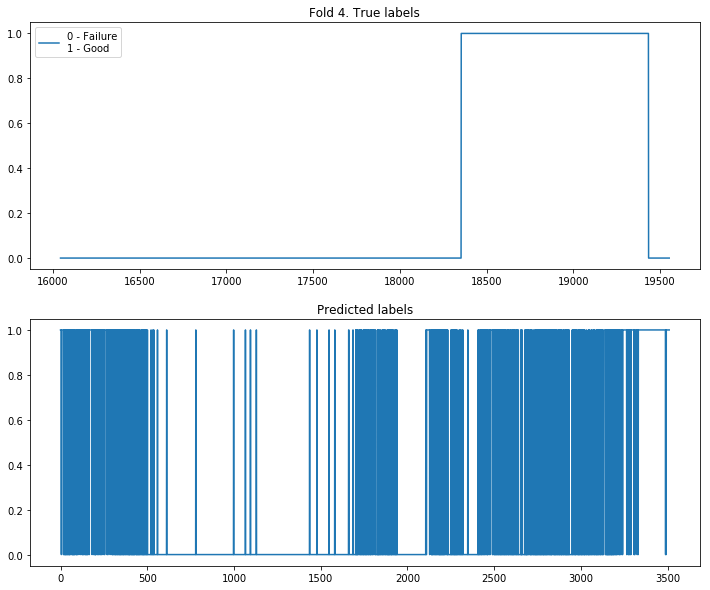

Test accuracy: 0.6516661919681003


In [119]:
fold_id = 3
ind_train, ind_test = list(kf.split(X))[fold_id]
X_train, X_test, y_train, y_test = train_test_split(X.iloc[ind_train], y.iloc[ind_train], test_size=0.25, shuffle=False)
model = lgb.LGBMClassifier(**(log[fold_id]['params']))
model.fit(X_train, y_train, eval_set=(X_train, y_train), early_stopping_rounds=30, verbose=False)

plt.subplot(2,1,1)
plt.plot(y_test[1:])
plt.legend(["0 - Failure\n1 - Good"])
plt.title("Fold %d. True labels" % (fold_id + 1))
plt.subplot(2,1,2)
plt.plot(model.predict(X_test)[1:])
plt.title("Predicted labels")
plt.show()
print("Test accuracy:", accuracy_score(y_test, model.predict(X_test)))

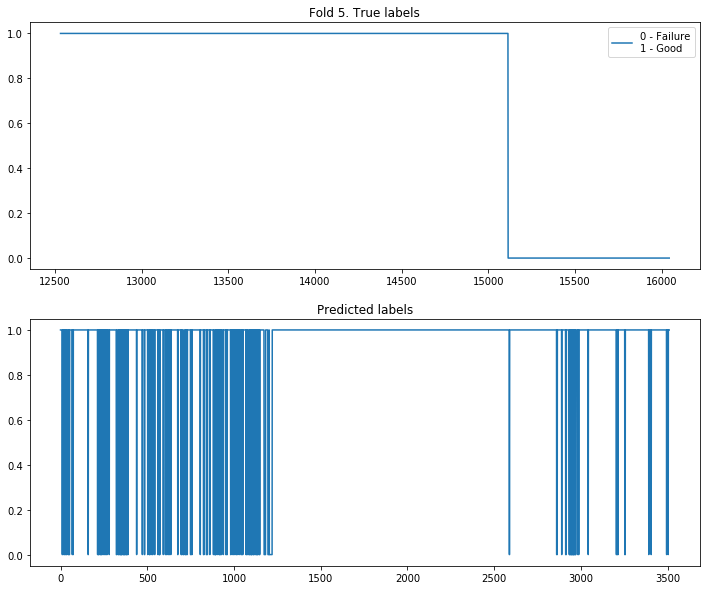

Test accuracy: 0.6904015949871831


In [120]:
fold_id = 4
ind_train, ind_test = list(kf.split(X))[fold_id]
X_train, X_test, y_train, y_test = train_test_split(X.iloc[ind_train], y.iloc[ind_train], test_size=0.25, shuffle=False)
model = lgb.LGBMClassifier(**(log[fold_id]['params']))
model.fit(X_train, y_train, eval_set=(X_train, y_train), early_stopping_rounds=30, verbose=False)

plt.subplot(2,1,1)
plt.plot(y_test)
plt.legend(["0 - Failure\n1 - Good"])
plt.title("Fold %d. True labels" % (fold_id + 1))
plt.subplot(2,1,2)
plt.plot(model.predict(X_test))
plt.title("Predicted labels")
plt.show()
print("Test accuracy:", accuracy_score(y_test, model.predict(X_test)))

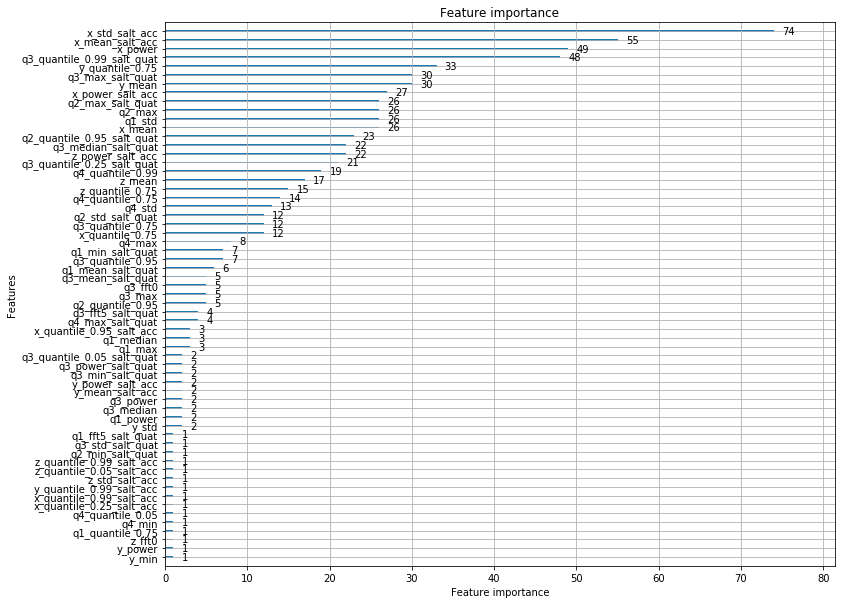

In [121]:
lgb.plot_importance(model)
plt.show()

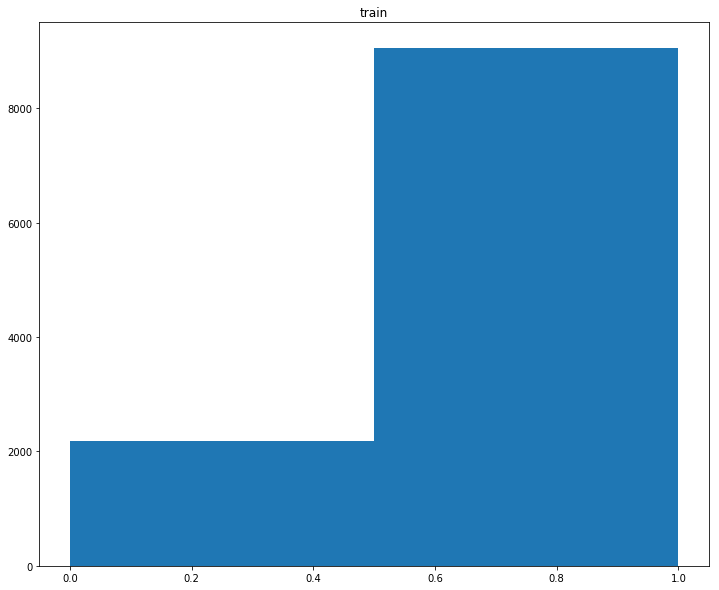

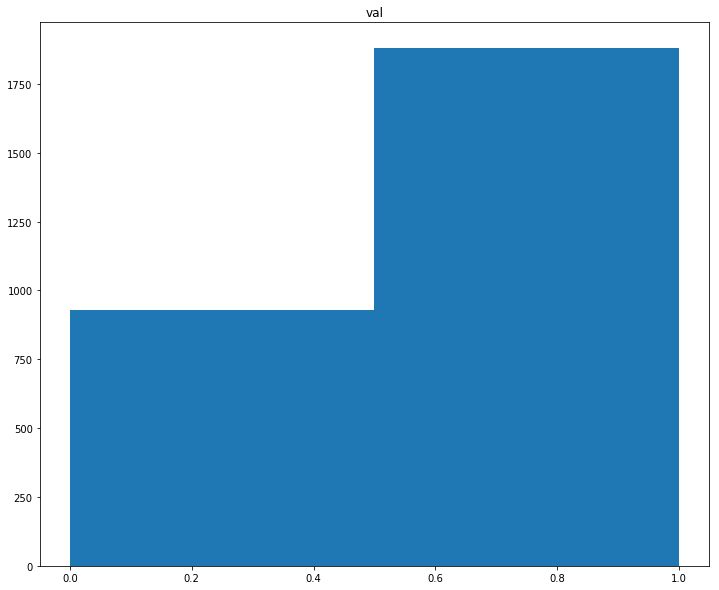

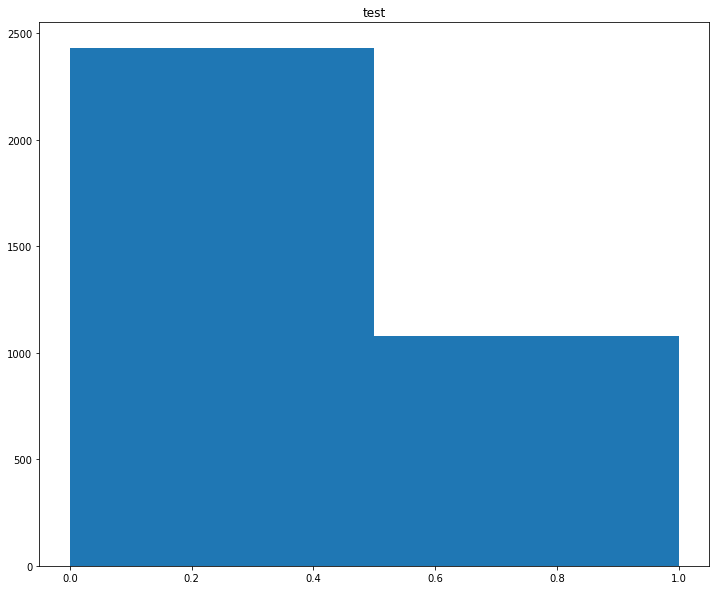

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

plt.hist(y_train, bins=2)
plt.title("train")
plt.show()
plt.hist(y_val, bins=2)
plt.title('val')
plt.show()
plt.hist(y_test, bins=2)
plt.title('test')
plt.show()

In [79]:
model = lgb.LGBMClassifier(**log[4]['params'])
model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=30, verbose=False)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.005,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=50, n_jobs=-1, num_leaves=16,
        objective='binary', random_state=1234, reg_alpha=1, reg_lambda=0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [80]:
print("Train acc:", accuracy_score(y_train, model.predict(X_train)))
print("Valid acc:", accuracy_score(y_val, model.predict(X_val)))
print("Test acc:", accuracy_score(y_test, model.predict(X_test)))

Train acc: 0.8696813245504718
Valid acc: 0.6447134211463155
Test acc: 0.5941327257191683


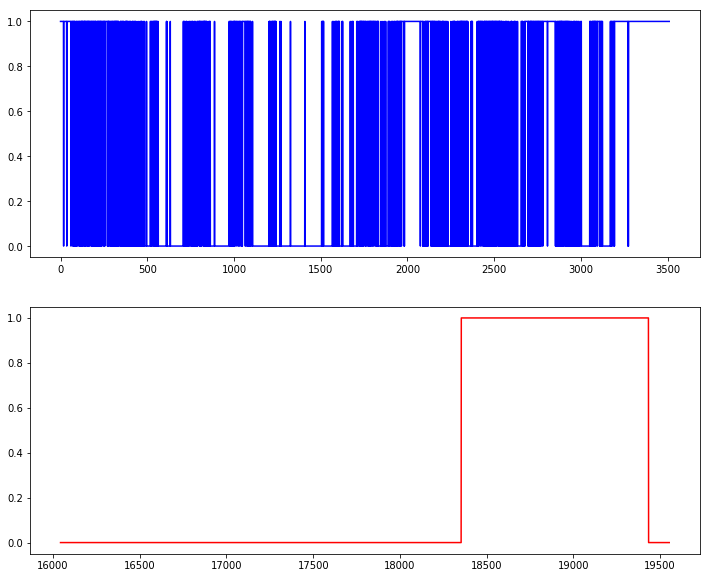

In [81]:
plt.subplot(2,1,1)
plt.plot(model.predict(X_test), color='blue')
plt.subplot(2,1,2)
plt.plot(y_test, color='red')
plt.show()